In [99]:
import logging, os

import numpy as np
import astropy.io.ascii as at
import matplotlib.pyplot as plt
%matplotlib inline
from astroML import time_series

import hypra.prot.fix_kepler
import hypra.prot.time_series

from k2spin import lc
from k2spin import k2io
from k2spin import plot
from k2spin import prot
reload(lc)
reload(plot)

<module 'k2spin.plot' from '/home/stephanie/code/python/k2spin/plot.pyc'>

First, read in the lightcurve and run necessary corrections

In [80]:
def std_ratio(y, cadence):

    y_use = y[np.isfinite(y)]
    six_hr = 0.25 / cadence

    six_hr_std = np.zeros_like(y_use)
    for i in range(6,len(y_use)-6):
        six_hr_std[i] = np.std(y_use[i-6:i+6])
    logging.debug("std y %f 6hr %f",np.std(y_use), np.median(six_hr_std))
    
    return np.std(y_use)/np.median(six_hr_std)

def choose_lc(lcs):
    cadence = np.median(np.diff(lcs["t"]))

    ap_cols = []
    std_rat = []
    for colname in lcs.dtype.names:
        good_flux = len(np.where(np.isfinite(lcs[colname]))[0])
        if ("flux" in colname) and (good_flux>2000):
            ap_cols.append(colname)
            std_rat.append(std_ratio(lcs[colname], cadence))
    ap_cols = np.array(ap_cols)
    std_rat = np.array(std_rat)
    print ap_cols

    best_col = ap_cols[np.argmax(std_rat)]
    print "Using %s" % best_col 
    return best_col

['flux_2.0' 'flux_2.5' 'flux_3.0' 'flux_3.5' 'flux_4.0' 'flux_4.5'
 'flux_5.0' 'flux_5.5']
Using flux_2.5


/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


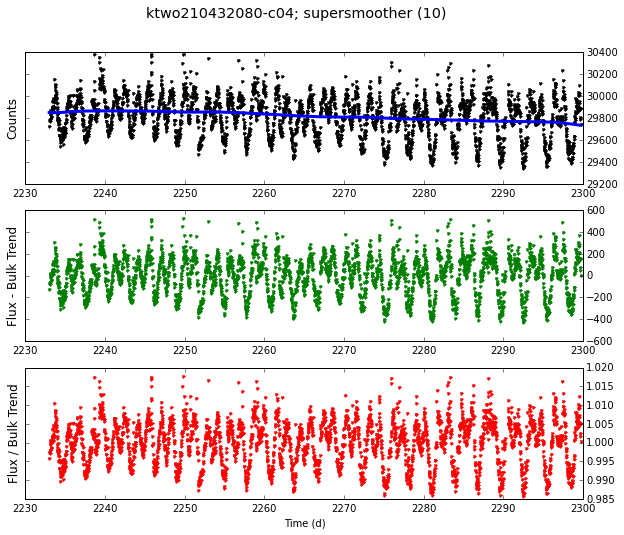

In [90]:
lc_dir = "/home/stephanie/code/python/k2phot/lcs/"
#filename = "ktwo210359769-c04.csv"
filename = "ktwo-c04.csv"
#filename = "ktwo210365286-c04.csv"
#filename = "ktwo210384590-c04.csv"
#filename = "ktwo210408563-c04.csv"
filename = "ktwo210432080-c04.csv"

lcs = at.read(lc_dir+filename)

time = lcs["t"]
x_pos = lcs["x"]
y_pos = lcs["y"]
qual_flux = np.zeros_like(time)
best_col = choose_lc(lcs)
best_col = "flux_4.0"
flux = lcs[best_col]
unc_flux = np.ones_like(time)

    
detrend_kwargs={"kind":"supersmoother","phaser":10}
use_time = (time>2233)
light_curve = lc.LightCurve(time[use_time], flux[use_time], 
                            unc_flux[use_time], 
                            x_pos[use_time], y_pos[use_time],
                            name=filename[:-4],
                            detrend_kwargs=detrend_kwargs)
#light_curve.choose_initial()
#light_curve.correct_and_fit()


t = light_curve.time
y = light_curve.flux
dy = light_curve.unc_flux

t = light_curve.time
y = light_curve.det_flux
dy = light_curve.det_unc

ls_init = prot.run_ls(t, y, dy, threshold=0.5,
                      prot_lims=[0.1,max_prot], run_bootstrap=True)

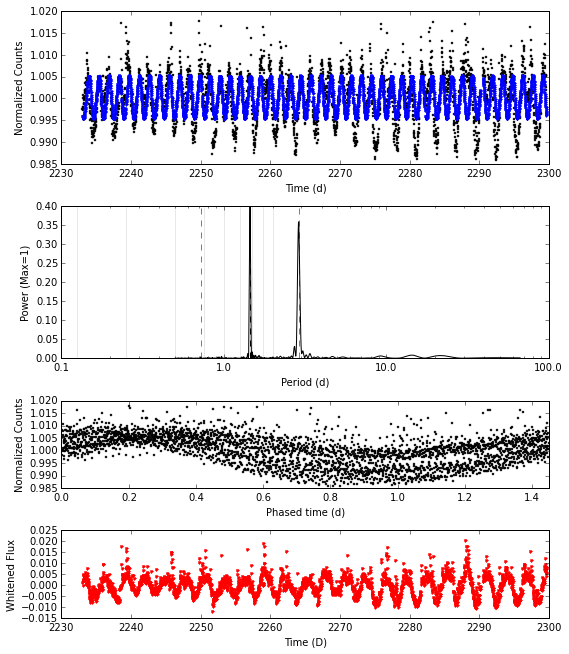

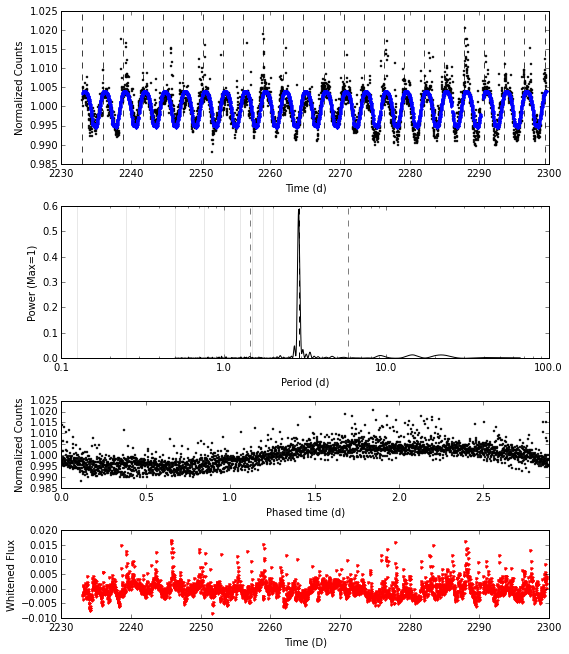

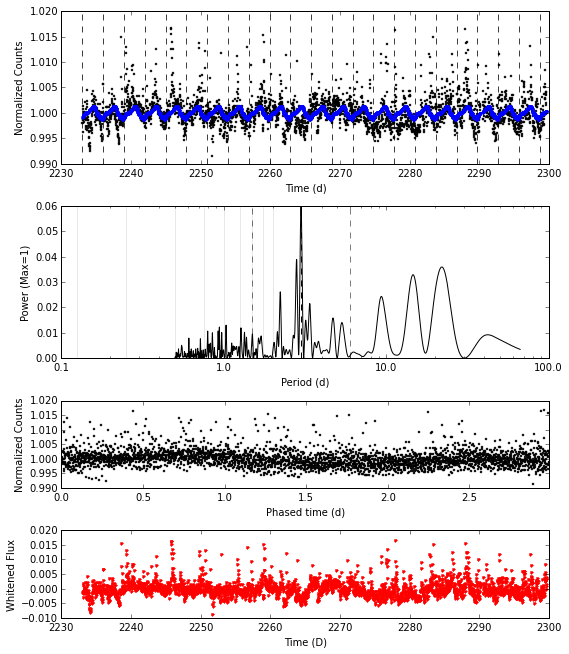

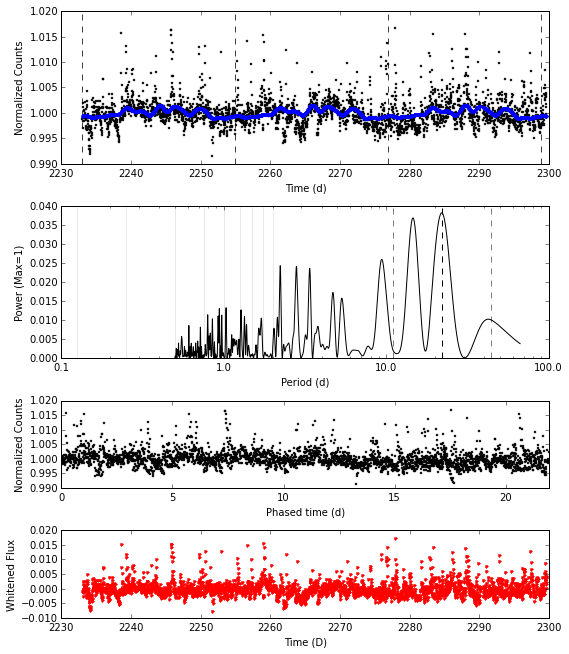

In [91]:
reload(prot)
det_kwargs = {"kind":"supersmoother","filename":light_curve.name}
#det_kwargs = {"kind":"boxcar","phaser":six_hr*4}
max_prot = t[-1] - t[0]
flat_flux, flat_unc = prot.detrend_for_correction(t, y, dy, 
                                                  prot_lims=[0.5,max_prot],
                                                  to_plot=True,
                                                  **det_kwargs)

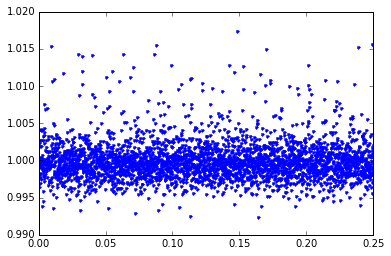

In [92]:
phased_time = t % 0.25
plt.plot(phased_time, flat_flux,'b.')

In [93]:
light_curve.use_flux = y
light_curve.use_unc = dy
light_curve._xy_correct(correct_with=flat_flux, n_closest=40)

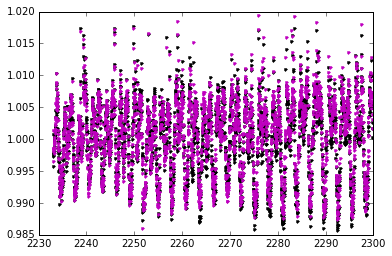

In [94]:
plt.plot(t, y, 'k.')
plt.plot(t, light_curve.corrected_flux, 'm.')

In [95]:
ls_out = prot.run_ls(t, light_curve.corrected_flux, 
                     light_curve.corrected_unc, threshold=0.5,
                     prot_lims=[0.1,max_prot], run_bootstrap=True)

1.44930574556


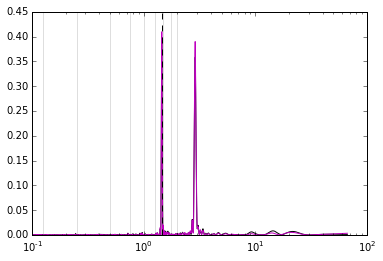

In [96]:
plt.plot(ls_init[2], ls_init[3], 'k-')
plt.plot(ls_out[2], ls_out[3], 'm-')
plt.xscale("log")
plt.xlim(0.1,100)
ax = plt.gca()
ax.axvline(ls_out[0],color='k',ls='--')
harmonics = np.append(0.125,np.arange(0.25,2.1,0.25))
for harm in harmonics:
    ax.axvline(harm, color="LightGrey", linestyle="-",
               alpha=0.75, zorder=-111)
print ls_out[0]

In [97]:
ls_out

(1.4493057455621565,
 0.40955955128821858,
 array([ 66.668884  ,  65.22164007,  63.8358945 , ...,   0.10000999,
          0.10000666,   0.10000333]),
 array([  3.41996428e-03,   3.34784487e-03,   3.26741232e-03, ...,
          1.67630424e-05,   1.84506121e-05,   2.02958868e-05]),
 array([ 0.21322027,  0.11507499,  0.0788023 ,  0.30211348,  0.13679863,
         0.08841722]),
 array([ 0.00530154,  0.00526197]))

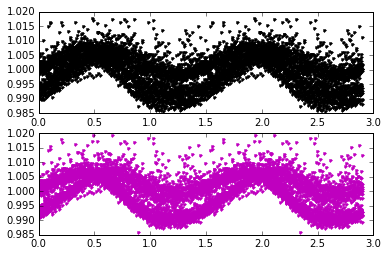

In [98]:
plt.figure()
ax = plt.subplot(211)
ax.plot(t % ls_init[0], y, 'k.')
ax.plot(t % ls_init[0] + ls_init[0], y, 'k.')
ax = plt.subplot(212)
ax.plot(t % ls_out[0], light_curve.corrected_flux, 'm.')
ax.plot(t % ls_out[0] + ls_out[0], light_curve.corrected_flux, 'm.')